<a href="https://colab.research.google.com/github/rayxsun/gender-equality-policy-supervised-machine-learning/blob/main/SUN_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 Assignment
Task: Apply the supervised machine learning methods to measure a target concept of your choice.

You'll need to apply two different models and compare their performance in the validation set.

The two different models can be one random forest and one pre-trained large language model; or can be one random forest model using bag-of-words vectorization and one random forest model using word embedding vectorization.

Submission: A short report on your supervised classification. Two Pages maximum with 12 pt and double space.

Your short report should include:

1. In one paragraph, explain the target concept you seek to measure, the data you use for measuring the concept.

2. In two or three paragraphs, describe the process of your supervised method.

3. In one to two paragraphs, report and compare the model performance. You can include confusion matrix for both models, ROC curves, or simply report in words their accuracy/precision/recall/f1 score etc. Figures do not count towards the 2 pages upper limit.

In [ ]:
# install evaluate module
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found 

In [ ]:
import evaluate

# select the evaluation metrix
metric = evaluate.combine(["precision", "recall", "accuracy","f1"])

In [ ]:
# mount Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import modules

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# for training doc2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# for preprocess document in English
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_numeric

In [ ]:
data_path = '/content/drive/My Drive/Colab/ICPSR/assignment/'
dt= pd.read_csv(data_path + 'newsbank_china.csv')

In [ ]:
dt.tail()

,text,articleid,pos,date,year,source
428,"Even with the new second children policy, over...",Global_2017_03-13,11,13-Mar-17,2017,Global
429,But if more fathers took over such responsibil...,Global_2017_03-13,12,13-Mar-17,2017,Global
430,"""Take the opportunity, stay as much as you can...",Global_2017_03-13,13,13-Mar-17,2017,Global
431,Selected works from the photography contest wi...,Global_2017_03-13,14,13-Mar-17,2017,Global
432,Participants can submit their work from March ...,Global_2017_03-13,15,13-Mar-17,2017,Global


In [ ]:
# create a unique document id
# for each quasi-sentence
# use the manifesto_id and pos variable
dt["id_pos"] = dt["articleid"].astype(str) + "_" + dt["pos"].astype(str)

In [ ]:
# create a binary variable: gender equality, if text mentions fathers'responsibility or paternity
## define a function to create the 'equality' binary variable
def check_equality(text):
    keywords = ['father', 'fathers', 'men' ,'paternity']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0

# Apply the function to create the 'equality' column
dt['equality'] = dt['text'].apply(check_equality)

# Display the first few rows to verify the new column
dt.head()

,text,articleid,pos,date,year,source,id_pos,equality
0,A medical staff member cares for a newborn at ...,Global_2024_07-12,1,12-Jul-24,2024,Global,Global_2024_07-12_1,0
1,China has established a childbearing and child...,Global_2024_07-12,2,12-Jul-24,2024,Global,Global_2024_07-12_2,0
2,A demographer suggested that these policy meas...,Global_2024_07-12,3,12-Jul-24,2024,Global,Global_2024_07-12_3,1
3,Themed under advocating a focus on family educ...,Global_2024_07-12,4,12-Jul-24,2024,Global,Global_2024_07-12_4,1
4,"According to the NHC, all provinces have exten...",Global_2024_07-12,5,12-Jul-24,2024,Global,Global_2024_07-12_5,1


In [ ]:
dt["equality"].value_counts()

equality
0    235
1    198
Name: count, dtype: int64

In [ ]:
# create two copies of the current dt for different model training
dt1 = dt.copy() # dt1 for word embedding model
dt2 = dt.copy() # dt3 for pre-trained model

# preprare training data

In [ ]:
# we can sample a fraction of documents from each source
# remember to set random_state/seed
fraction = 0.3 # fraction of docs to sample per source, i use 0.3 instead of 0.02 because of my limited number of data, otherwise the later model performance is bad
sample = dt.groupby('source', group_keys=False).apply(
    lambda x: x.sample(frac=fraction, random_state=42)
)

In [ ]:
sample.head()

,text,articleid,pos,date,year,source,id_pos,equality
104,It is also important to improve nursery care s...,Daily_2023_06-13,36,13-Jun-23,2023,Daily,Daily_2023_06-13_36,1
389,The move has been welcomed by parents and neti...,Daily_2017_07-05,4,5-Jul-17,2017,Daily,Daily_2017_07-05_4,0
404,"""I would not be surprised if private companies...",Daily_2017_07-05,19,5-Jul-17,2017,Daily,Daily_2017_07-05_19,0
29,The fourth Chinese Women's Social Status Surve...,Daily_2024_04-09,10,9-Apr-24,2024,Daily,Daily_2024_04-09_10,1
178,"In Beijing, women enjoy 30 days of extra mater...",Daily_2022_01-12,19,12-Jan-22,2022,Daily,Daily_2022_01-12_19,1


In [ ]:
sample.equality.describe()

count    130.000000
mean       0.453846
std        0.499791
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: equality, dtype: float64

# 1. train a random forest model using bag of words vectorization

# preprocess, split handcoded texts

In [ ]:
# use spacy to preprocess

import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess(texts, n):
    docs = nlp.pipe(texts, batch_size= n)
    # remove punctuation & number
    processed_texts = []
    for doc in docs:
      tokens = [token.lemma_ for token in doc
                if not token.is_punct
                and not token.like_num]
      processed_texts.append(' '.join(tokens))
    return processed_texts


In [ ]:
# process the full corpus
processed_texts = preprocess(dt['text'], 800)

In [ ]:
# use sklearn to vectorize texts
# see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# for more details
from sklearn.feature_extraction.text import CountVectorizer

# build the vectorizer
# it simply tokenizes using white space
# then count the num of tokens
vectorizer = CountVectorizer()

In [ ]:
# vectorize sample texts
All_vectors = vectorizer.fit_transform(processed_texts)
All_vectors.shape

(433, 1634)

In [ ]:
# extract training sample feature maxtrix
X_vectors = All_vectors[sample.index]
X_vectors.shape

(130, 1634)

In [ ]:
Y_vectors = sample['equality']
Y_vectors.shape

(130,)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X, valid_X, train_Y, valid_Y = train_test_split(X_vectors, Y_vectors,
                                                      # 25% as validation set
                                                      test_size=0.25,
                                                      # stratify using the Y labels
                                                      stratify= Y_vectors,
                                                      random_state=42)

Key Parameters:

- n_estimators: Number of trees in the forest.
- max_features: Maximum number of features considered for splitting a node.
- max_depth: Maximum depth of the trees.
- class_weight='balanced': Automatically adjusts weights inversely proportional to class frequencies. This helps the model pay more attention to minority classes.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3,
                                  random_state=42, class_weight="balanced")
rf_model.fit(train_X, train_Y) # the example codes: n_estimators=1000, max_depth=5, but I tried 100 and 3

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=42)

## Evaluate model performance on validation set


In [ ]:
# using the X feature and the trained model
# to predit the Y label
rf_pred = rf_model.predict(valid_X)


In [ ]:
# give the function the predictions and "groundtruth"
metric.compute(predictions = list(rf_pred), references= list(valid_Y))

{'precision': 0.8333333333333334,
 'recall': 0.3333333333333333,
 'accuracy': 0.6666666666666666,
 'f1': 0.47619047619047616}

In [ ]:
# in-sample model performance
rf_pred_train = rf_model.predict(train_X)
metric.compute(predictions = list(rf_pred_train), references= list(train_Y))

{'precision': 1.0,
 'recall': 0.7045454545454546,
 'accuracy': 0.865979381443299,
 'f1': 0.8266666666666667}

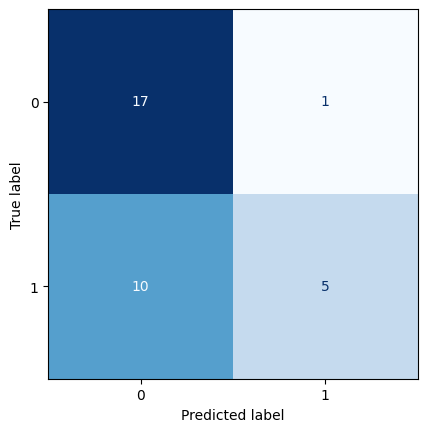

In [ ]:
conf_matrix = confusion_matrix(valid_Y, rf_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', colorbar=False)
# save a plot to local folder
plt.savefig(data_path + 'confusion_matrix.png')
plt.show()


In [ ]:
# import module for roc curve

from sklearn.metrics import roc_curve, auc

In [ ]:
# for roc and auc,
# we need to calculate predicted probablity

rf_pred_prob = rf_model.predict_proba(valid_X)

In [ ]:
# predicted probability results
# include probability for all categories
rf_pred_prob

array([[0.55274936, 0.44725064],
       [0.5709402 , 0.4290598 ],
       [0.51967562, 0.48032438],
       [0.47378919, 0.52621081],
       [0.57732553, 0.42267447],
       [0.51708739, 0.48291261],
       [0.58047965, 0.41952035],
       [0.4919717 , 0.5080283 ],
       [0.43379383, 0.56620617],
       [0.56836876, 0.43163124],
       [0.50903269, 0.49096731],
       [0.56923207, 0.43076793],
       [0.55976522, 0.44023478],
       [0.50848878, 0.49151122],
       [0.57876721, 0.42123279],
       [0.52507217, 0.47492783],
       [0.58193149, 0.41806851],
       [0.58899632, 0.41100368],
       [0.53209058, 0.46790942],
       [0.54645305, 0.45354695],
       [0.40876701, 0.59123299],
       [0.59385911, 0.40614089],
       [0.46822495, 0.53177505],
       [0.43399061, 0.56600939],
       [0.54389488, 0.45610512],
       [0.5331665 , 0.4668335 ],
       [0.57110128, 0.42889872],
       [0.54058523, 0.45941477],
       [0.58925831, 0.41074169],
       [0.54700034, 0.45299966],
       [0.

In [ ]:
# calculate false/true positive rate
# for ROC, we extract the 2nd dimension of
# predicted probability for being 1
fpr, tpr, thresholds = roc_curve(valid_Y, rf_pred_prob[:,1])

# calculate auc
roc_auc = auc(fpr, tpr)
roc_auc

0.7703703703703704

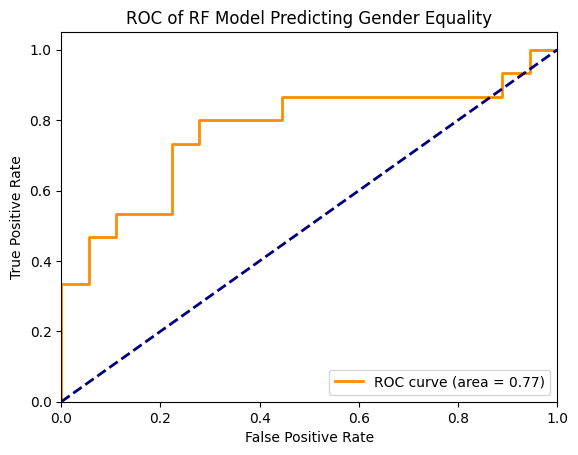

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RF Model Predicting Gender Equality')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# return false positive

list(sample['text'].iloc[np.where(rf_model.predict(X_vectors) - Y_vectors == 1)[0]])

['Currently, maternity leave can be taken for at least 98 days.']

## Hyper-parameter tuning

### Gridsearch

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [5, 8, 10],
    'max_depth': [None, 2, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
#Grid Search with Cross-Validation
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(random_state=42)

# Define the GridSearchCV
# cv: num of folds for crossvalidation
# n_jobs = -1: using all CPU units for parallel computing
# verbose =2: returning detailed progress report
# scoring: evaluation matrices for grid search
# scoreing can be accuracy, precision, recall, f1
grid_search = GridSearchCV(estimator=RF, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(train_X, train_Y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [5, 8, 10]},
             scoring='f1', verbose=2)

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}


In [ ]:
# Get the best estimator
best_rf = grid_search.best_estimator_

In [ ]:
best_pred_prob = best_rf.predict_proba(valid_X)

In [ ]:
fpr, tpr, thresholds = roc_curve(valid_Y, best_pred_prob[:,1])

# calculate auc
roc_auc = auc(fpr, tpr)
roc_auc

0.8333333333333333

### investigate important features

In [ ]:
feature_importance_df = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': rf_model.feature_importances_})

In [ ]:
feature_importance_df.sort_values(by='importance', ascending=False)[:20]

,feature,importance
1585,woman,0.056247
874,maternity,0.034809
603,government,0.031678
804,leave,0.031362
1467,to,0.026619
161,believe,0.025243
537,father,0.021232
1559,well,0.019964
859,man,0.018843
1399,such,0.017747


### visualize tree

In [ ]:
from graphviz import Source
from sklearn import tree

In [ ]:
tree_graph = Source(tree.export_graphviz(rf_model.estimators_[4], # visulize the first tree
                    out_file = None,
                    class_names = ['Other', 'equality'],
                    feature_names = vectorizer.get_feature_names_out(),
                    rounded = True, proportion = False,
                    precision = 2, # number of digits for float number
                    filled = True))

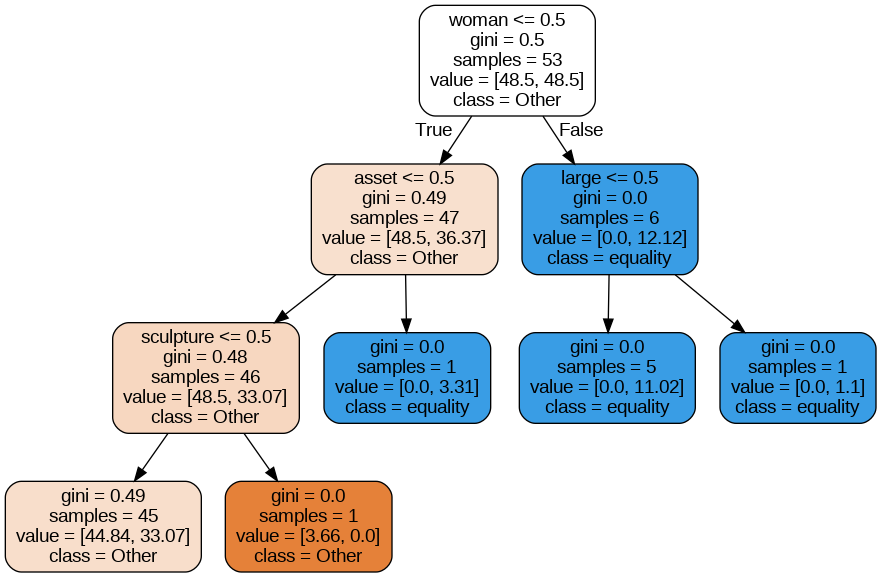

In [ ]:
# turn the previous dot file into png format
png_bytes = tree_graph.pipe(format='png')

# write the png figure file into your drive
with open(data_path + 'tree_pipe.png','wb') as f:
    f.write(png_bytes)

# display impage
from IPython.display import Image
Image(png_bytes)

### predict labels for all data

In [ ]:
# apply .predict method to the feature matrix of full corpus
rf_pred_all = rf_model.predict(All_vectors)
rf_pred_all_prob = rf_model.predict_proba(All_vectors)

In [ ]:
# add them to the original dataset
dt['rf_pred'] = rf_pred_all
# save the predicted probability for being positive only
dt['rf_pred_prob'] = rf_pred_all_prob[:,1]

In [ ]:
dt.rf_pred.describe()

count    433.000000
mean       0.263279
std        0.440922
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: rf_pred, dtype: float64

# 2. # 1. train a random forest model using word embedding vectorization

## train local doc2vec

In [ ]:
# first pre-process the corpus
# we can do a minimum preprocess
## gensim does not have lower function, so we use lambda function
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation,
                  strip_multiple_whitespaces, strip_numeric]

processed_corpus = [preprocess_string(x, CUSTOM_FILTERS) for x in dt1.text]

In [ ]:
processed_corpus[:3]

[['a',
  'medical',
  'staff',
  'member',
  'cares',
  'for',
  'a',
  'newborn',
  'at',
  'the',
  'neonatal',
  'care',
  'unit',
  'of',
  'a',
  'hospital',
  'in',
  'lianyungang',
  'east',
  'china',
  's',
  'jiangsu',
  'province',
  'on',
  'january'],
 ['china',
  'has',
  'established',
  'a',
  'childbearing',
  'and',
  'child',
  'rearing',
  'supporting',
  'system',
  'with',
  'a',
  'number',
  'of',
  'policies',
  'rolled',
  'out',
  'in',
  'localities',
  'across',
  'the',
  'country',
  'including',
  'extending',
  'maternity',
  'leave',
  'to',
  'days',
  'or',
  'longer',
  'raising',
  'childbirth',
  'allowance',
  'and',
  'child',
  'rearing',
  'subsidies',
  'and',
  'providing',
  'more',
  'professional',
  'and',
  'affordable',
  'babysitter',
  'services',
  'at',
  'childcare',
  'institutions',
  'central',
  'china',
  'television',
  'reported',
  'on',
  'thursday',
  'the',
  'th',
  'world',
  'population',
  'day',
  'citing',
  'offi

In [ ]:
# create numeric tag for each document
tagged_docs = [TaggedDocument(words=doc,
                              tags=[str(i)]) for i, doc in enumerate(processed_corpus)]

In [ ]:
tagged_docs[0]

TaggedDocument(words=['a', 'medical', 'staff', 'member', 'cares', 'for', 'a', 'newborn', 'at', 'the', 'neonatal', 'care', 'unit', 'of', 'a', 'hospital', 'in', 'lianyungang', 'east', 'china', 's', 'jiangsu', 'province', 'on', 'january'], tags=['0'])

we can use the Doc2vec model in gensim to train our word embedding

Doc2vec documentation: https://radimrehurek.com/gensim/models/doc2vec.html

Important hyper-parameters:

- vector_size: Dimensionality of the embedding vectors
- window: The maximum distance between the current and predicted word within a - sentence (to be considered target, context pair)
- min_count: include words appear at least N time.
- epochs: number of times we pass the entire corpus through the network.

In [ ]:
# Initialize the model
model = Doc2Vec(vector_size=100, min_count=1, epochs=20,
                window = 5, negative=10)# can try different numbers, but don't let the window size larger than 10

# Build the vocabulary
model.build_vocab(tagged_docs)

# Train the model
model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# save the mode locally
model.save(data_path + "d2v_model.model")

In [ ]:
# second model
model2 = Doc2Vec(vector_size=150, min_count=1, epochs=20,
                window = 4, negative=10)# can try different numbers, but don't let the window size larger than 10

# Build the vocabulary
model2.build_vocab(tagged_docs)

# Train the model
model2.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

## descriptive analysis using trained embeddings

In [ ]:
# Load the saved model
model = Doc2Vec.load(data_path + "d2v_model.model")

### word analogy & similarities; one way to validate our embedding

In [ ]:
result = model.wv.most_similar(positive=['mother', 'women'],
                               negative=['men'], topn=10)
print(result)

[('senior', 0.9991500973701477), ('number', 0.9990928173065186), ('regional', 0.9990913271903992), ('about', 0.9990882277488708), ('chen', 0.9990877509117126), ('jiangsu', 0.9990726709365845), ('solution', 0.9990700483322144), ('growth', 0.9990648627281189), ('this', 0.9990644454956055), ('by', 0.999053955078125)]


In [ ]:
# second model result
result2 = model2.wv.most_similar(positive=['mother', 'women'],
                               negative=['men'], topn=10)
print(result2)

[('this', 0.999305784702301), ('province', 0.9992685914039612), ('from', 0.9992603063583374), ('by', 0.9992432594299316), ('career', 0.999228835105896), ('companies', 0.999224066734314), ('before', 0.9992159605026245), ('positive', 0.9991989135742188), ('over', 0.9991954565048218), ('us', 0.9991917610168457)]


In [ ]:
# look for similar words to one word
similar_words = model.wv.most_similar("parental", topn=5)
print(similar_words)

[('paternity', 0.9994399547576904), ('maternity', 0.9989407658576965), ('days', 0.997752845287323), ('extended', 0.997674822807312), ('extending', 0.9975051879882812)]


### find similar documents

In [ ]:
# finding similar documents
# .dv.most_similar() takes embedding vector as input
# .dv feature returns document vectors
print(dt1.text[3])
# look for the most similar document to the 4th document in corpus
similar_docs = model.dv.most_similar([model.dv[3]])
print(similar_docs)

Themed under advocating a focus on family education and traditions and cultivation of marriage and child-rearing by the NHC, this year's population day aims to raise public awareness about further addressing China's declining birth rates in recent years and the demographic issues that may affect China's sustainable development.
[('3', 1.0), ('41', 0.9995797872543335), ('65', 0.9995000958442688), ('329', 0.9994957447052002), ('25', 0.9994463920593262), ('280', 0.9994382262229919), ('231', 0.9994381666183472), ('421', 0.9994276165962219), ('310', 0.99942547082901), ('325', 0.999423623085022)]


In [ ]:
doc_index = [int(item[0]) for item in similar_docs]
similarities = [item[1] for item in similar_docs]

similarities

[1.0,
 0.9995797872543335,
 0.9995000958442688,
 0.9994957447052002,
 0.9994463920593262,
 0.9994382262229919,
 0.9994381666183472,
 0.9994276165962219,
 0.99942547082901,
 0.999423623085022]

In [ ]:
# return the most similar documents before preprocessing
similar_docs = [dt1["text"].iloc[i] for i in doc_index]
similar_docs

["Themed under advocating a focus on family education and traditions and cultivation of marriage and child-rearing by the NHC, this year's population day aims to raise public awareness about further addressing China's declining birth rates in recent years and the demographic issues that may affect China's sustainable development.",
 "The makeover of a sculpture of a typical Chinese family at a park in Wuhan, Hubei province, soared to the top of microblogging platform Sina Weibo's trending list at the beginning of this year, generating 39 million views.",
 'The upcoming Year of the Dragon may be a silver lining or a shot in the arm for growth prospects as there is a traditional preference for babies born in the Year of the Dragon, Zhai Zhenwu, president of the China Population Association, told Time News, a news outlet in Guangdong province.',
 'So, a gradual increase in the retirement age and equal retirement age for men and women as well as full exploitation of the opportunities from 

In [ ]:
# infer a new document's vector representation
new_doc = "implementing paternity leave can promote gender equality"
new_doc_vector = model.infer_vector(preprocess_string(new_doc, CUSTOM_FILTERS))
print(new_doc_vector)

[-6.90354919e-03 -4.82094660e-03 -2.59906482e-02 -8.04222934e-03
  2.25466061e-02 -3.53500098e-02 -5.29650657e-04  4.37202454e-02
 -2.53414568e-02 -1.54445330e-02 -1.49010718e-02 -1.36111900e-02
 -1.37957539e-02 -2.57540215e-03  1.74306687e-02 -1.05773527e-02
  2.13714726e-02 -3.78648750e-02 -1.35994256e-02 -4.17535156e-02
  1.93576198e-02  4.37585264e-03 -4.86366265e-03 -1.10514536e-02
  1.35340877e-02 -5.82040008e-03 -1.21583289e-03  4.82271006e-03
 -3.05584278e-02 -5.01642516e-03  4.21142243e-02  8.51756614e-03
  4.74799331e-03  1.78219343e-03 -9.11826547e-03  2.70115715e-02
  1.13807935e-02 -2.72980873e-02  1.44814225e-02 -2.92239450e-02
  1.66915562e-02 -1.53292753e-02  1.06279785e-02 -1.86251104e-02
  3.54666990e-04 -5.88786602e-03 -1.24785639e-02  1.03020156e-02
  3.81185021e-03  7.66387256e-03  4.87674333e-05  1.64419529e-03
 -2.21277941e-02  4.44255676e-03 -2.53236555e-02  1.60550568e-02
  1.38661591e-02 -8.63320194e-03 -1.07190062e-04  5.25855809e-04
  1.67831704e-02  2.27976

In [ ]:
# use the infered embedding of the new doc
# to find the most similar documents to the new doc
similar_docs = model.dv.most_similar([new_doc_vector])
print(similar_docs)

[('4', 0.8876781463623047), ('179', 0.866715133190155), ('178', 0.8615837693214417), ('140', 0.8604824542999268), ('210', 0.8583111763000488), ('223', 0.8562078475952148), ('387', 0.8555363416671753), ('250', 0.8554701805114746), ('115', 0.8553293347358704), ('5', 0.8545119166374207)]


In [ ]:
doc_index = [int(item[0]) for item in similar_docs]
similar_docs = [dt1["text"].iloc[i] for i in doc_index]
similar_docs

['According to the NHC, all provinces have extended maternity leave by 60 days or more, and have set 15 days of paternity leave for families with newborns.',
 "In Northeast China's Liaoning province, the paid parental leave for mothers and fathers will amount to 10 days, and new dads will enjoy 20 days of paternity leave.",
 'In Beijing, women enjoy 30 days of extra maternity leave, and both parents will have five days of parental leave every year before their child turns 3.',
 "An additional 15 days of paternity leave has been granted to working fathers during their wife's maternity leave.",
 "In northeast China's Liaoning, the paid parental leave for mothers and fathers will amount to 10 days, and new dads will enjoy 20 days of paternity leave.",
 'Localities including Beijing, Sichuan and Jiangxi have rolled out supportive measures highlighting increased leave for couples, such as offering parental leave, extending maternity leave and marriage leave, and increasing paternity leave.'

## using trained embedding for classification

In [ ]:
# create a randoms ample of english texts as "labeled" training data
fraction = 0.3 # fraction of docs to sample per source, i use 0.3 instead of 0.02 because of my limited number of data, otherwise the later model performance is bad
sample = dt1.groupby('source', group_keys=False).apply(
    lambda x: x.sample(frac=fraction, random_state=42)
)


In [ ]:
# we already have vectorized all documents using doc2vec
# now we only need to subset the sample's vectors and labels

X_vectors = [model.dv[i] for i in sample.index]
print(len(X_vectors))

Y_vectors = sample['equality']
print(Y_vectors.shape)

130
(130,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X_vectors, Y_vectors, stratify= Y_vectors,
                                                    test_size=0.25, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [5, 8, 10],
    'max_depth': [None, 2, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
#Grid Search with Cross-Validation
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier(random_state=42)

# Define the GridSearchCV
# cv: num of folds for crossvalidation
# n_jobs = -1: using all CPU units for parallel computing
# verbose =2: returning detailed progress report
# scoring: evaluation matrices for grid search
# scoreing can be accuracy, precision, recall, f1
grid_search = GridSearchCV(estimator=RF, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [5, 8, 10]},
             scoring='f1', verbose=2)

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 5}


In [ ]:
# evaluate performance for the best model using word embedding
# Get the best estimator
best_rf = grid_search.best_estimator_

best_pred_prob = best_rf.predict_proba(X_valid)

fpr, tpr, thresholds = roc_curve(Y_valid, best_pred_prob[:,1])

# calculate auc
roc_auc = auc(fpr, tpr)
roc_auc

0.625925925925926

## using pre-trained word embedding

In [ ]:
#download and load pretrained model
import gensim.downloader as api

model_gigaword = api.load("glove-wiki-gigaword-100")

KeyboardInterrupt: 

In [ ]:
# all previous descriptive analyses apply to pretrained embedding
model_gigaword.most_similar(positive=['employer', 'women'],
                               negative=['men'], topn=10)

[('employers', 0.6831456422805786),
 ('benefits', 0.6509779095649719),
 ('beneficiary', 0.6400823593139648),
 ('pension', 0.6265221834182739),
 ('spouse', 0.620891273021698),
 ('employee', 0.615679144859314),
 ('retiree', 0.6136007308959961),
 ('insurance', 0.6023076772689819),
 ('benefit', 0.6016466021537781),
 ('medicaid', 0.5940744876861572)]

In [ ]:
# calculate the vector for each document
# using pretrained embedding

# functon to create an average vector for one document
def get_average_vector(doc, model):
    vector = np.mean([model[token] for token in doc if token in model], axis=0)
    if np.isnan(vector).any():
        return np.zeros(model.vector_size)
    return vector

# function to return document embedding for the full corpus
def get_document_vectors(processed_docs, model):
    return np.array([get_average_vector(doc, model) for doc in processed_docs])

In [ ]:
# extraxt texts in our sampled "labeled" training data
labeled_texts = [processed_corpus[i] for i in sample.index]

In [ ]:
X_vectors = get_document_vectors(labeled_texts, model_gigaword)
print(len(X_vectors))

Y_vectors = sample['equality']
Y_vectors.shape

130


(130,)

In [ ]:
# Split the data into training and testing sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X_vectors, Y_vectors, stratify= Y_vectors,
                                                    test_size=0.25, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=5, max_depth=5,
                                  min_samples_split=2, min_samples_leaf=4,
                                  random_state=42, class_weight="balanced")
rf_model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4,
                       n_estimators=5, random_state=42)

In [ ]:
# evaluate performance f

rf_pred_prob = rf_model.predict_proba(X_valid)

fpr, tpr, thresholds = roc_curve(Y_valid, rf_pred_prob[:,1])

# calculate auc
roc_auc = auc(fpr, tpr)
roc_auc

0.6037037037037037

## Evaluate model performance on validation set


In [ ]:
# using the X feature and the trained model
# to predit the Y label
rf_pred = rf_model.predict(X_valid)

In [ ]:
# give the function the predictions and "groundtruth"
metric.compute(predictions = list(rf_pred), references= list(Y_valid))

{'precision': 0.5263157894736842,
 'recall': 0.6666666666666666,
 'accuracy': 0.5757575757575758,
 'f1': 0.5882352941176471}

In [ ]:
# in-sample model performance
rf_pred_train = rf_model.predict(X_train)
metric.compute(predictions = list(rf_pred_train), references= list(Y_train))

{'precision': 0.8666666666666667,
 'recall': 0.8863636363636364,
 'accuracy': 0.8865979381443299,
 'f1': 0.8764044943820225}

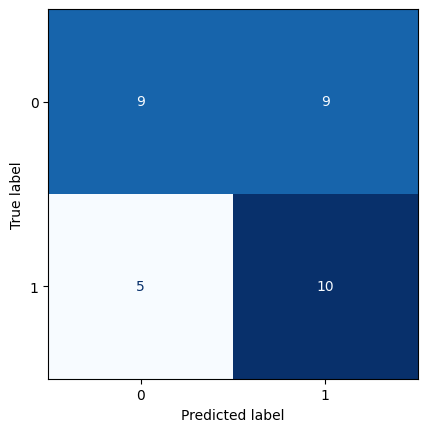

In [ ]:
conf_matrix = confusion_matrix(Y_valid, rf_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', colorbar=False)
# save a plot to local folder
plt.savefig(data_path + 'confusion_matrix.png')
plt.show()


In [ ]:
# import module for roc curve

from sklearn.metrics import roc_curve, auc

In [ ]:
# for roc and auc,
# we need to calculate predicted probablity

rf_pred_prob = rf_model.predict_proba(X_valid)

In [ ]:
# predicted probability results
# include probability for all categories
rf_pred_prob

array([[0.39554716, 0.60445284],
       [0.80986547, 0.19013453],
       [0.47119521, 0.52880479],
       [0.03417486, 0.96582514],
       [0.2604252 , 0.7395748 ],
       [0.25321522, 0.74678478],
       [0.77639198, 0.22360802],
       [0.65969058, 0.34030942],
       [0.61463571, 0.38536429],
       [0.6747009 , 0.3252991 ],
       [0.39285263, 0.60714737],
       [0.47981859, 0.52018141],
       [0.98026071, 0.01973929],
       [0.57193914, 0.42806086],
       [0.45494769, 0.54505231],
       [0.36117216, 0.63882784],
       [0.44424047, 0.55575953],
       [0.4       , 0.6       ],
       [0.83249383, 0.16750617],
       [0.46854986, 0.53145014],
       [0.47772475, 0.52227525],
       [0.72938402, 0.27061598],
       [0.39607776, 0.60392224],
       [0.12405906, 0.87594094],
       [0.53357361, 0.46642639],
       [0.8403259 , 0.1596741 ],
       [0.70563006, 0.29436994],
       [0.41967944, 0.58032056],
       [0.48291861, 0.51708139],
       [0.15847763, 0.84152237],
       [0.

In [ ]:
# calculate false/true positive rate
# for ROC, we extract the 2nd dimension of
# predicted probability for being 1
fpr, tpr, thresholds = roc_curve(Y_valid, rf_pred_prob[:,1])

# calculate auc
roc_auc = auc(fpr, tpr)
roc_auc

0.6037037037037037

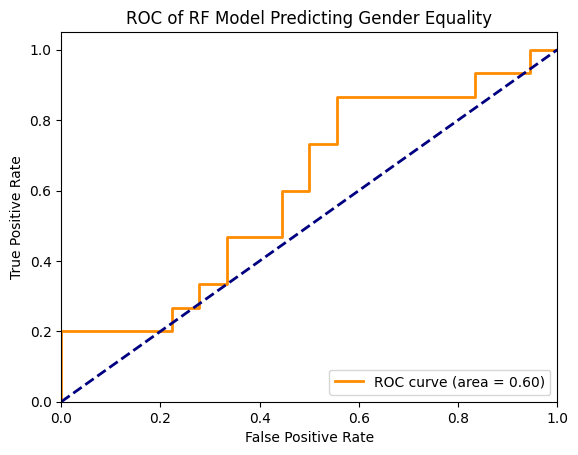

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of RF Model Predicting Gender Equality')
plt.legend(loc='lower right')
plt.show()

## visualize tree

In [ ]:
from graphviz import Source
from sklearn import tree

In [ ]:
tree_graph = Source(tree.export_graphviz(rf_model.estimators_[4], # visulize the first tree
                    out_file = None,
                    class_names = ['Other', 'equality'],
                    feature_names = vectorizer.get_feature_names_out(),
                    rounded = True, proportion = False,
                    precision = 2, # number of digits for float number
                    filled = True))

ValueError: Length of feature_names, 1634 does not match number of features, 100

#  3. use pre-trained LLMs

In [ ]:
# read more about this package:
# https://huggingface.co/docs/evaluate/en/index
# import pipleline module
from transformers import pipeline

## zero-shot classification

In [ ]:
# specify a model in pipeline()
# use a multilingual zero-shot model
# read the model card: https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7
classifier = pipeline(task="zero-shot-classification",
                      model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [ ]:
# specify the labels
issue_labels = ["gender equality", "gender inequality"]
# Convert the 'text' column to a list of strings
sentences = dt2["text"].tolist()


# Define a function to classify a single sentence
def classify_sentence(sentence):
    result = classifier(sentences, issue_labels, multi_label = True)
    return result

# Apply the classifier to the list of sentences
classification_results = [classify_sentence(sentence) for sentence in sentences]

# Add the results back to the DataFrame
dt2['classification'] = classification_results

# Display the results
print(dt2.head())


KeyboardInterrupt: 

## finetune

In [ ]:
# we can sample a fraction of documents from each source
# remember to set random_state/seed
fraction = 0.3 # fraction of docs to sample per source, i use 0.3 instead of 0.02 because of my limited number of data, otherwise the later model performance is bad
sample = dt2.groupby('source', group_keys=False).apply(
    lambda x: x.sample(frac=fraction, random_state=42)
)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(sample, test_size=0.25, random_state=42)

In [ ]:
from datasets import Dataset

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'equality']])
test_dataset = Dataset.from_pandas(test_df[['text', 'equality']])

In [ ]:
train_dataset

Dataset({
    features: ['text', 'equality', '__index_level_0__'],
    num_rows: 97
})

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# model name
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding="max_length",
                     return_tensors='tf',
                     truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['text', 'equality', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 97
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["equality"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=50,
)


tf_test_dataset = test_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["equality"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=50,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy # need to specify loss function
from tensorflow.keras.optimizers import Adam

In [ ]:
batch_size = 8
num_epochs = 5
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)




In [ ]:
opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy()



In [ ]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7dffefe82890>

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=5)

In [ ]:
preds = model.predict(tf_test_dataset)["logits"]

class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)